In [74]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
# great library sourcing here...
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, _tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from logitboost import LogitBoost

import imodels
import sys
#sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

# default plotting properties - has to be an easier way then doing this every notebook
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# what is the purpose of this cell with the bottom one also? - probably delete this later on
df = Dataset().clean_data(data_path = data_path)
df = Dataset().preprocess_data(df)
df_train, df_tune, _ = Dataset().split_data(df)
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values
processed_feats = df_train.keys().values.tolist()
feature_names = list(X_train)


def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.52it/s]
/Users/marko/rule-vetting/rule-env/lib/python3.9/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [55]:
simple_var_list = ['InjuryMech_Assault',
       'InjuryMech_Bicyclist struck by automobile',
       'InjuryMech_Bike collision/fall', 'InjuryMech_Fall down stairs',
       'InjuryMech_Fall from an elevation',
       'InjuryMech_Fall to ground standing/walking/running',
       'InjuryMech_Motor vehicle collision',
       'InjuryMech_Object struck head - accidental',
       'InjuryMech_Other mechanism', 'InjuryMech_Other wheeled crash',
       'InjuryMech_Pedestrian struck by moving vehicle', 'InjuryMech_Sports',
       'InjuryMech_Walked/ran into stationary object',
       'High_impact_InjSev_High', 'High_impact_InjSev_Low',
       'High_impact_InjSev_Moderate', 'Amnesia_verb_No', 
       'Amnesia_verb_Pre/Non-verbal', 'Amnesia_verb_Yes',
       'LOCSeparate_No', 'LOCSeparate_Suspected', 'LOCSeparate_Yes', 
       'Seiz', 'ActNorm', 'HA_verb_No', 'HA_verb_Pre/Non-verbal', 'HA_verb_Yes',
        'Vomit', 'Intubated', 'Paralyzed', 'Sedated',
       'GCSTotal', 'GCSGroup', 'AMS', 'SFxPalp_No', 'SFxPalp_Unclear', 'SFxPalp_Yes',
       'FontBulg', 'Hema', 'Clav', 'NeuroD', 'OSI', 'Drugs', 'AgeTwoPlus', 'Gender', 'outcome']

df_simp = df[simple_var_list]

# Excluding samples with GCS score < 14 and dropping GCSGroup indicator
df_simp = df_simp[df_simp['GCSTotal'] >= 14]
df_simp = df_simp.drop(columns=["GCSGroup"])

# splits for simplified data 
df_simp_train, df_simp_tune, df_simp_test = Dataset().split_data(df_simp)
X_simp_train = df_simp_train.drop(columns=outcome_def)
y_simp_train = df_simp_train[outcome_def].values
X_simp_tune = df_simp_tune.drop(columns=outcome_def)
y_simp_tune = df_simp_tune[outcome_def].values
X_simp_test = df_simp_test.drop(columns=outcome_def)
y_simp_test = df_simp_test[outcome_def].values
processed_feats_simp = df_simp_train.keys().values.tolist()
feature_names_simp = list(X_simp_train)

In [56]:
df_simp_train.head()

,InjuryMech_Assault,InjuryMech_Bicyclist struck by automobile,InjuryMech_Bike collision/fall,InjuryMech_Fall down stairs,InjuryMech_Fall from an elevation,InjuryMech_Fall to ground standing/walking/running,InjuryMech_Motor vehicle collision,InjuryMech_Object struck head - accidental,InjuryMech_Other mechanism,InjuryMech_Other wheeled crash,...,SFxPalp_Yes,FontBulg,Hema,Clav,NeuroD,OSI,Drugs,AgeTwoPlus,Gender,outcome
14091,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,2,0,0
20231,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
15798,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,0
223,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
6635,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,0


# Fitting models to simple data - we need a pipeline*

## Logistic regression

0.8703309201677347
0.992458166391704


100%|██████████████████████████████████████| 3355/3355 [00:03<00:00, 927.81it/s]


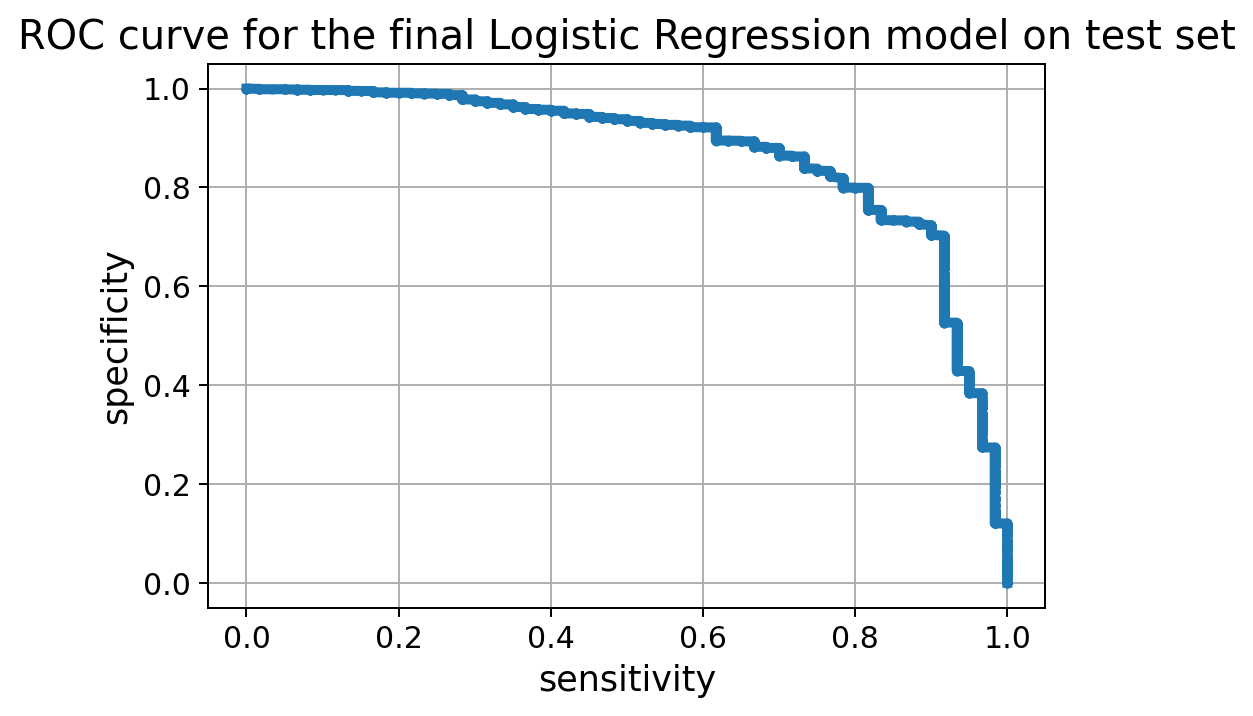

In [57]:
processed_feats_simp = df_simp_train.keys().values.tolist()
feature_names_simp = list(X_simp_train)

# Now fitting logistic regression
logreg_model = LogisticRegression(solver='liblinear', random_state = 0).fit(X_simp_train, y_simp_train)
roc_auc_score(y_simp_train, logreg_model.predict_proba(X_simp_train)[:, 1])  # Train AUC : 0.9513

# Tuning logistic regression
roc_tune = []
acc_tune = []
for lamb in [0.001, 0.01, 0.1, 1, 2, 5, 10] :
    logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(X_simp_train, y_simp_train)
    roc_tune.append(roc_auc_score(y_simp_tune, logreg_model.predict_proba(X_simp_tune)[:, 1]))
    acc_tune.append(logreg_model.score(X_simp_tune, y_simp_tune))
    
np.around(roc_tune, 5) # [0.90894, 0.91271, 0.91609, 0.91635, 0.91627, 0.91622, 0.91627]
np.around(acc_tune, 5) # [0.98376, 0.98629, 0.9871 , 0.98687, 0.98687, 0.98687, 0.98687]


# Using 1 as final regularization
logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(pd.concat([X_simp_train, X_simp_tune], axis = 0), 
                                                                                      np.hstack((y_simp_train, y_simp_tune)))
print(roc_auc_score(y_simp_test, logreg_model.predict_proba(X_simp_test)[:, 1]))  # 0.94451
print(logreg_model.score(X_simp_test, y_simp_test))  # 0.98583

# Plot the result for the test set
validation.all_stats_curve(y_simp_test, logreg_model.predict_proba(X_simp_test)[:, 1], plot = True)
plt.title('ROC curve for the final Logistic Regression model on test set')
plt.show()

## Boosted (LogitBoost & AdaBoost)

/Users/marko/rule-vetting/rule-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/marko/rule-vetting/rule-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


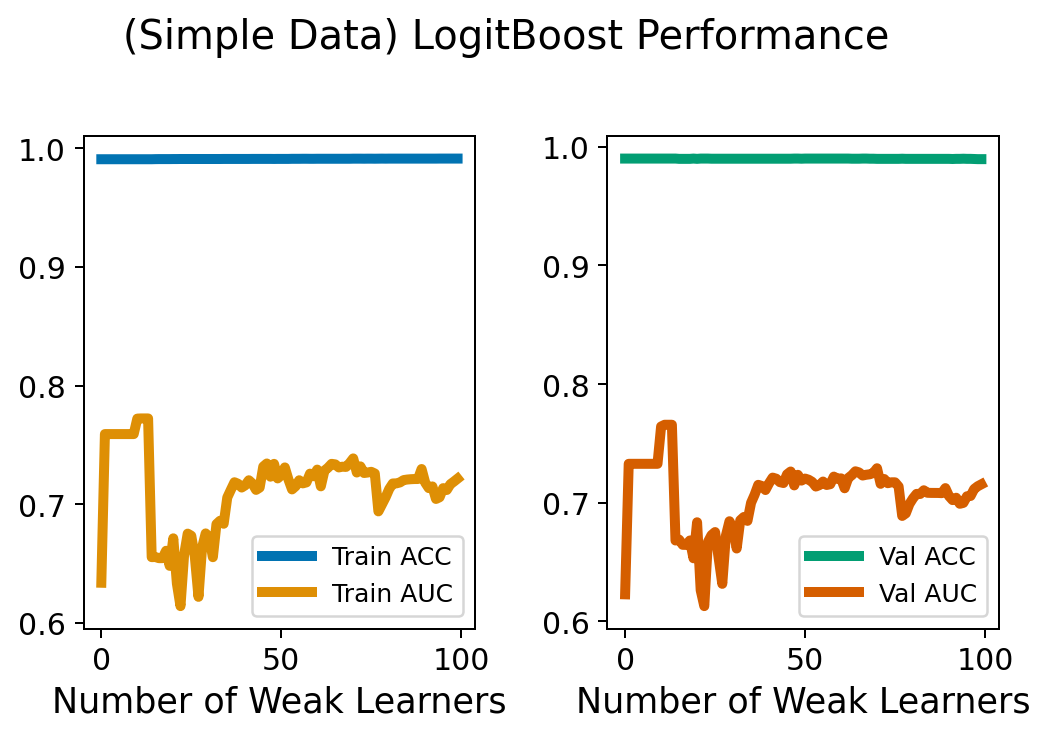

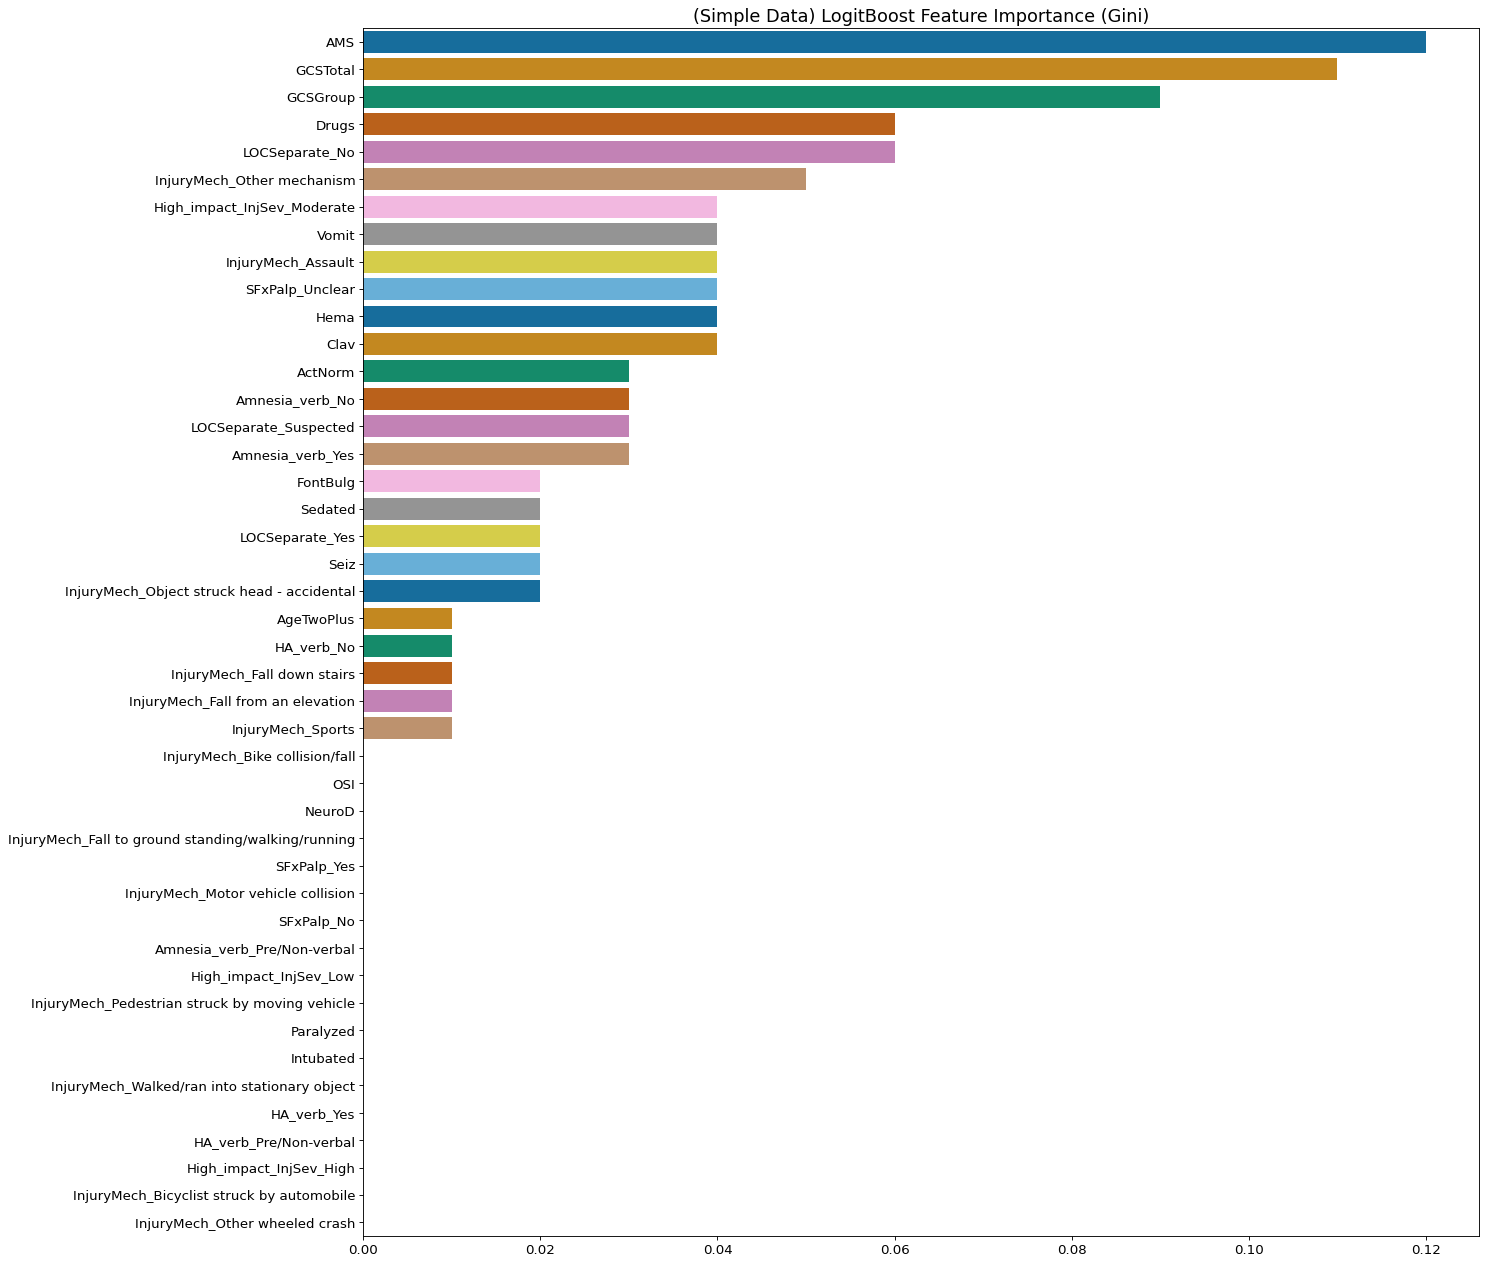

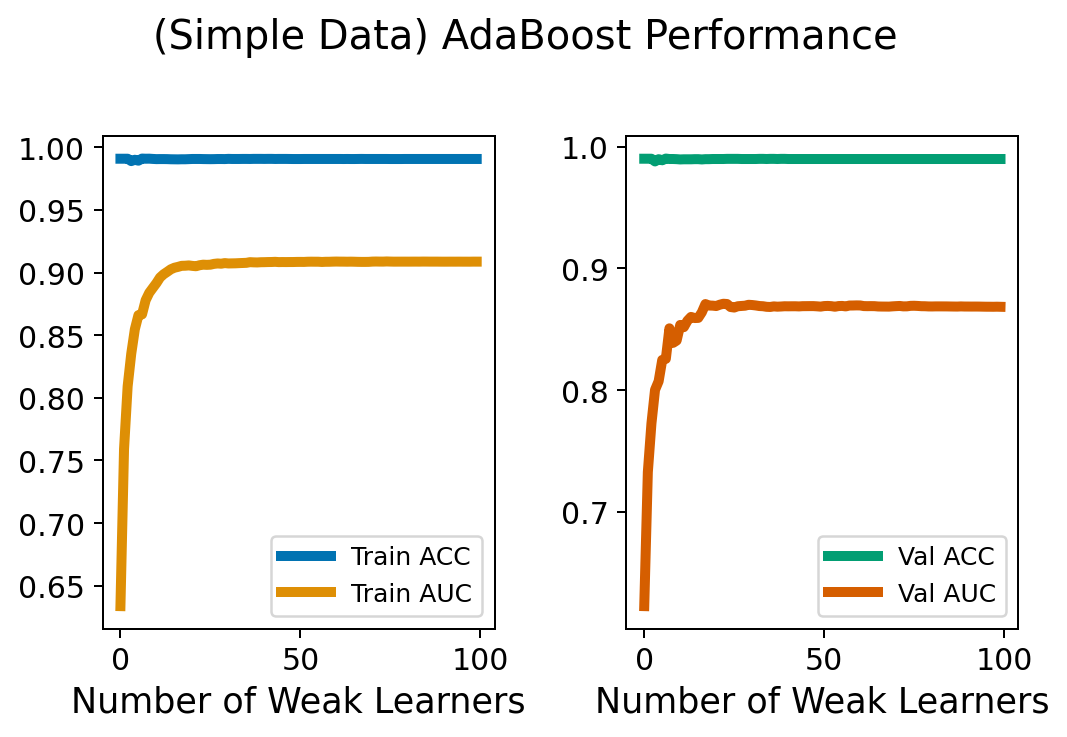

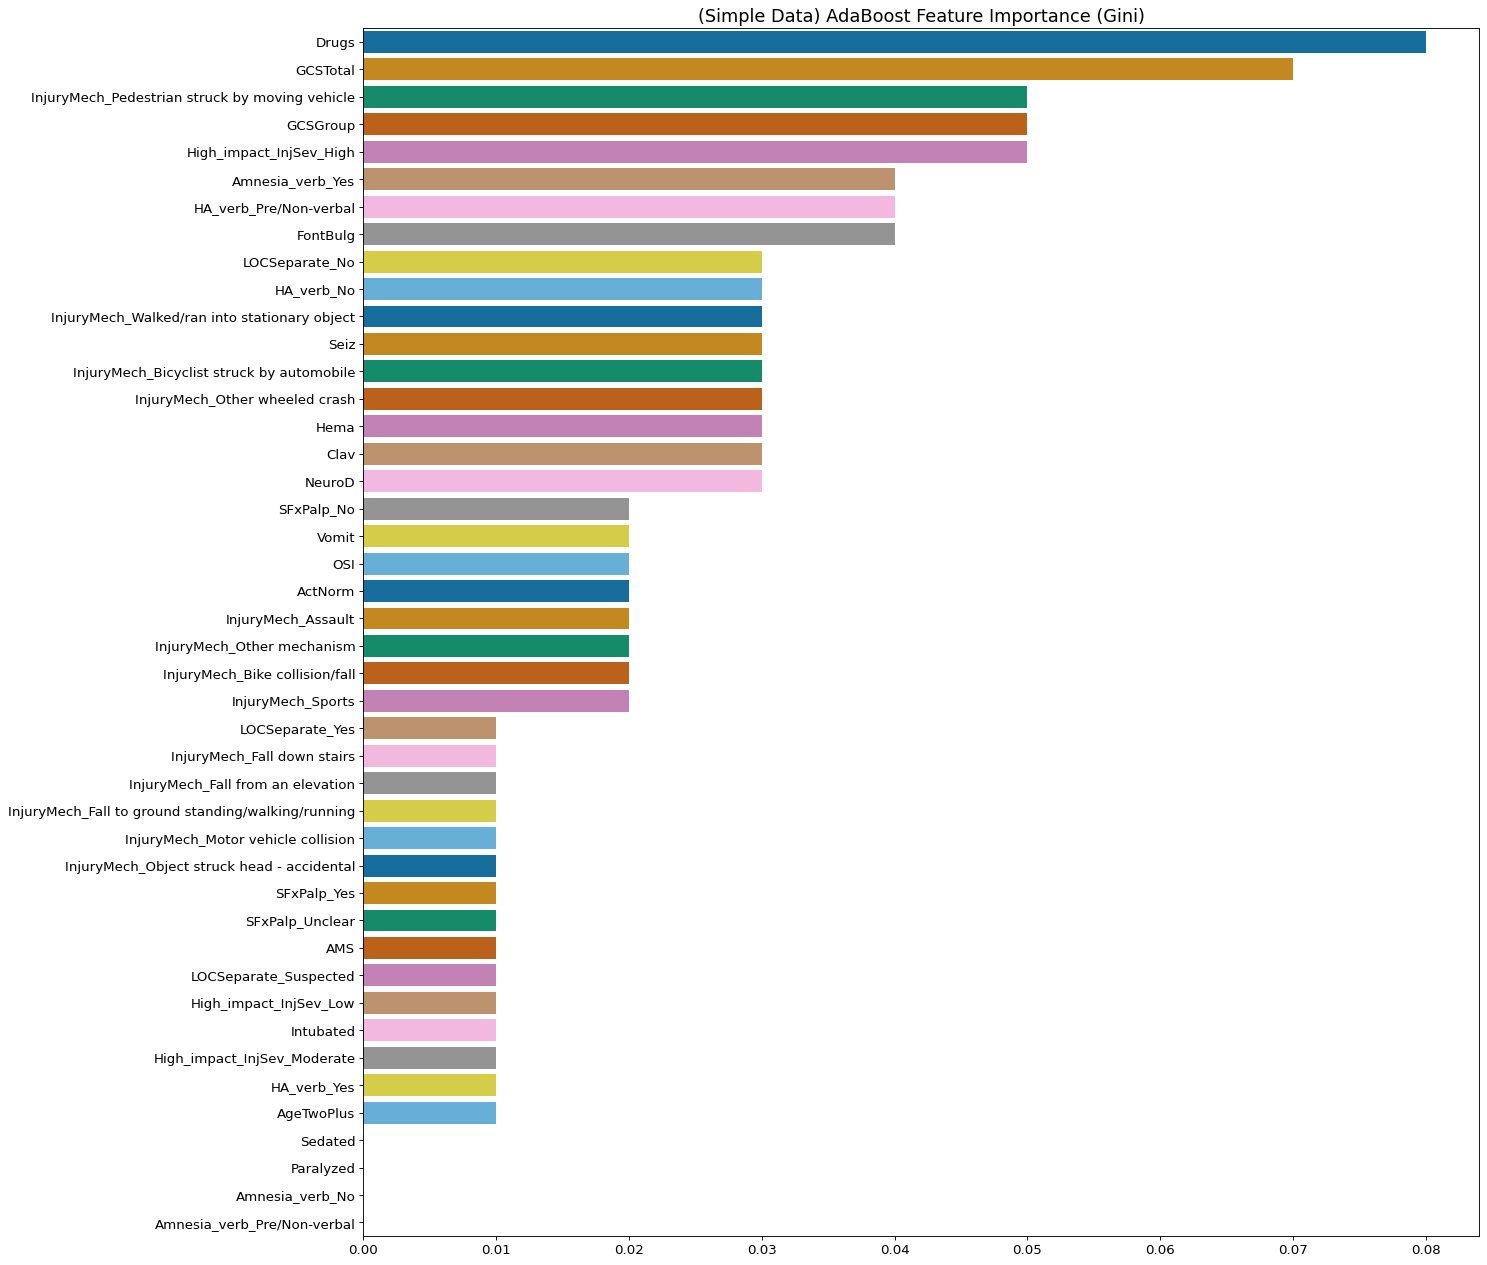

In [59]:
import warnings

def fit_eval_boosted(model, X_train, y_train, X_val, y_val, title_str):
    # Fit model
    model.fit(X_train, y_train)
    
    # Find accuracies on train/val sets
    # This takes ~2 minutes to run
    auc_train = []
    acc_train = []
    auc_val = []
    acc_val = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_pred = list(model.staged_predict_proba(X_train))
        val_pred = list(model.staged_predict_proba(X_val))
        for tp in train_pred:
            auc_train.append(roc_auc_score(y_train, tp[:, 1]))
            acc_train.append((y_train == tp.argmax(axis=1)).mean())
            
        for vp in val_pred:
            auc_val.append(roc_auc_score(y_val, vp[:, 1]))
            acc_val.append((y_val == vp.argmax(axis=1)).mean())

    # Plot ACC/AUC as function of number of weak learners
    plt.figure()
    plt.suptitle(title_str + " Performance", y=1.02)

    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label="Train ACC", color=color_list[0])
    plt.plot(auc_train, label="Train AUC", color=color_list[1])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_val, label="Val ACC", color=color_list[2])
    plt.plot(auc_val, label="Val AUC", color=color_list[3])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.tight_layout()
    
    # Plot Feature Importances
    barplot(pd.Series(dict(zip(simple_var_list[:-1], 
                           model.feature_importances_))).sort_values(ascending=False),
        False, title_str + " Feature Importance (Gini)"
       )
    
    return (model, {"acc_train" : acc_train, "auc_train" : auc_train, "acc_val" : acc_val, "auc_val" : auc_val})

# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)
lboost = LogitBoost(n_estimators=100, random_state=0)
lboost, lboost_perf = fit_eval_boosted(lboost, X_simp_train, y_simp_train, X_simp_tune, y_simp_tune, "(Simple Data) LogitBoost")

# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)
aboost = AdaBoostClassifier(n_estimators=100, random_state=0)
aboost, aboost_perf = fit_eval_boosted(aboost, X_simp_train, y_simp_train, X_simp_tune, y_simp_tune, "(Simple Data) AdaBoost")

## Decision Tree

ROC Scores: [0.72 0.77 0.77 0.78 0.78 0.7  0.62 0.55 0.53 0.55 0.55 0.56 0.55 0.55
 0.55 0.56 0.54 0.52 0.5  0.52 0.51 0.51 0.51 0.5  0.5  0.5  0.51 0.5
 0.5  0.5  0.5  0.51 0.5  0.5  0.51 0.5  0.5  0.51 0.5  0.5  0.5  0.5
 0.5  0.51]

ACC Scores: [0.87 0.76 0.83 0.78 0.81 0.83 0.81 0.86 0.85 0.88 0.89 0.91 0.91 0.92
 0.93 0.94 0.94 0.94 0.95 0.95 0.95 0.95 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96 0.96
 0.96 0.96]

ROC of depth 5: 0.7751117572592768
ACC of depth 5: 0.8111006363422107


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 866.18it/s]


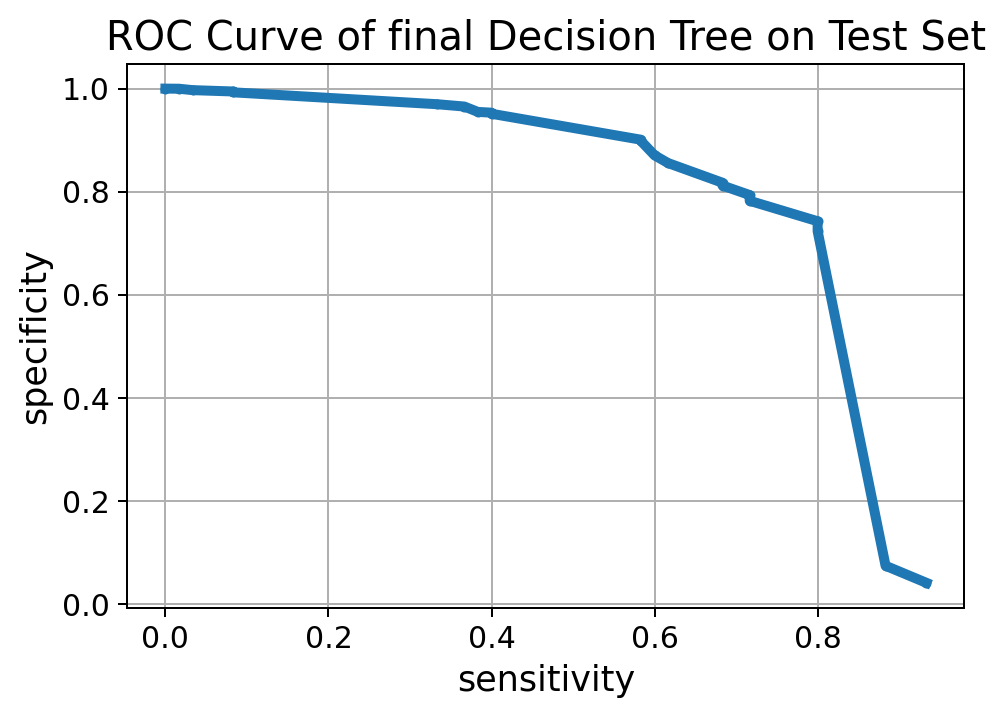

Feature Importances:

AMS            0.571
High_impact_InjSev_High     0.103
LOCSeparate_No     0.053
Clav           0.041
Hema           0.039
InjuryMech_Other wheeled crash     0.032
LOCSeparate_Yes     0.024
SFxPalp_Yes     0.020
Amnesia_verb_No     0.019
Vomit          0.016


if (NeuroDCranial <= 0.5)
 and (AMSOth <= 0.5)
 and (SFxBasRet > 0.5)
 and (AMSAgitated <= 0.5)
 and (OSI <= 0.5)
 then
	 class: No ciTBI (prob: 87.16%) | 16,316 samples


if (NeuroDCranial > 0.5)
 and (NeuroDSensory > 14.5)
 and (Hema <= 0.5)
 and (FontBulg <= 0.5)
 and (ClavNeck <= 0.5)
 then
	 class: ciTBI (prob: 75.97%) | 1,240 samples


if (NeuroDCranial <= 0.5)
 and (AMSOth > 0.5)
 and (OSICut <= 0.5)
 and (OSIFlank <= 0.5)
 and (OSICspine > 0.5)
 then
	 class: No ciTBI (prob: 60.29%) | 1,070 samples


if (NeuroDCranial <= 0.5)
 and (AMSOth > 0.5)
 and (OSICut > 0.5)
 and (NeuroDReflex > 0.5)
 and (Hema <= 0.5)
 then
	 class: ciTBI (prob: 55.1%) | 990 samples


if (NeuroDCranial <= 0.5)
 and (AMSOth > 0

In [77]:
# decision tree traversing func
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED 
                    else "Undefined!" for i in tree_.feature]
    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)    
    samples_count = [p[-1][1] for p in paths]
    sorted_samples = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(sorted_samples)]
    rules = []
    for path in paths:
        rule = "if "
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
            rule += '\n'
            
        rule += " then\n"
        if class_names is None:
            rule += "response: " + str(np.round(path[-1][0][0][0], 3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"\t class: {class_names[l]} (prob: {np.round(100 * classes[l] / np.sum(classes), 2)}%)"
        rule += f" | {path[-1][1]:,} samples\n\n"
        rules += [rule]
        
    return rules

# Tuning the depth of the tree
roc_tune = []
acc_tune = []
for depth in range(1, len(simple_var_list[:-1])):
    
    dt = DecisionTreeClassifier(max_depth=depth, class_weight={0: 1, 1:100})
    dt.fit(X_simp_train, y_simp_train)
    roc_tune.append(roc_auc_score(y_simp_tune, dt.predict_proba(X_simp_tune)[:, 1]))
    acc_tune.append(dt.score(X_simp_tune, y_simp_tune))

print(f'ROC Scores: {np.around(roc_tune, 2)}\n')
print(f'ACC Scores: {np.around(acc_tune, 2)}\n')

# use the depth 5
depth = 5
dt = DecisionTreeClassifier(max_depth=depth, class_weight={0: 1, 1:100})
dt.fit(X_simp_train, y_simp_train)
print(f'ROC of depth {depth}: {roc_auc_score(y_simp_test, dt.predict_proba(X_simp_test)[:, 1])}')
print(f'ACC of depth {depth}: {dt.score(X_simp_test, y_simp_test)}')
validation.all_stats_curve(y_simp_test, dt.predict_proba(X_simp_test)[:, 1], plot=True)
plt.title('ROC Curve of final Decision Tree on Test Set')
plt.show()

# important features
print('Feature Importances:\n')
for col, val in sorted(zip(X_simp_train.columns, dt.feature_importances_), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')

# plotting decision tree
fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=simple_var_list, class_names = ['No ciTBI', 'ciTBI'], filled=True)

# plotting probabilities for the different possibilities
print('\n')
rules = get_rules(dt, feature_names, ['No ciTBI', 'ciTBI'])
for rule in rules:
    print(rule)

## Bayesian Rule List

In [78]:
def simp_predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_simp_train, X_simp_tune],
                            [y_simp_train, y_simp_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BigDataRuleListClassifier(listlengthprior=2, max_iter=10000, class1label=1, verbose=False)
brl.fit(X_simp_train, y_simp_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

training bayesian_rule_list...


AttributeError: module 'imodels' has no attribute 'BigDataRuleListClassifier'

In [47]:
print(brl)

(Untrained RuleListClassifier)


## Rulefit

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1482.71it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

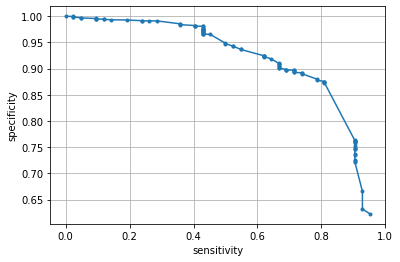

In [15]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [20]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
10,AbdTrauma_no,-0.01
11,AbdTrauma_or_SeatBeltSign_no,-0.02
12,AbdTrauma_or_SeatBeltSign_yes,0.00
29,GCSScore,-0.01
55,VomitWretch_no,-0.00
59,DecrBreathSound_yes <= 0.5 and AbdDistention_yes <= 0.5,-0.01
60,AbdDistention_yes <= 0.5 and AbdTenderDegree_Severe <= 0.5,-0.07
58,GCSScore > 9.5 and AbdTenderDegree_Severe <= 0.5,-0.01
61,VomitWretch_no > 0.5,-0.00


## Greedy (CART) Rule List

/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1109.18it/s]

mean 0.016 (7226 pts)
if AbdDistention >= 1.0 then 0.175 (166 pts)
mean 0.012 (7060 pts)
if feat 8 >= 1.0 then 0.121 (223 pts)
mean 0.009 (6837 pts)
if feat 50 >= 1.0 then 0.044 (615 pts)
mean 0.005 (6222 pts)
if feat 46 >= 1.0 then 0.029 (307 pts)
mean 0.004 (5915 pts)
if feat 6 >= 1.0 then 0.012 (805 pts)
mean 0.003 (5110 pts)
if feat 43 >= 3.0 then 0.02 (101 pts)
mean 0.002 (5009 pts)
if feat 18 >= 17.0 then 0.009 (459 pts)
mean 0.002 (4550 pts)
if feat 33 >= 1.0 then 0.024 (42 pts)
mean 0.001 (4508 pts)
if feat 35 >= 1.0 then 0.007 (302 pts)



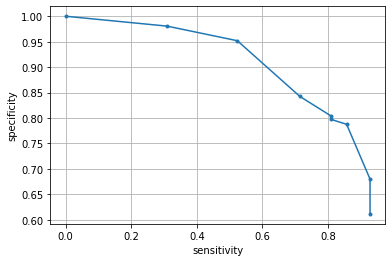

In [24]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

## Random Forest

In [25]:
# # specify a decision tree with a maximum depth
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
sens, spec, threshes = predict_and_save(rf, model_name='rf')
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])
imps = rf.feature_importances_.round(3)
args = np.argsort(imps)
imps = imps[args]
feats = np.array(processed_feats)[args]
for imp, feat in zip(imps, feats):
     print(feat, imp)

# Analyze Results

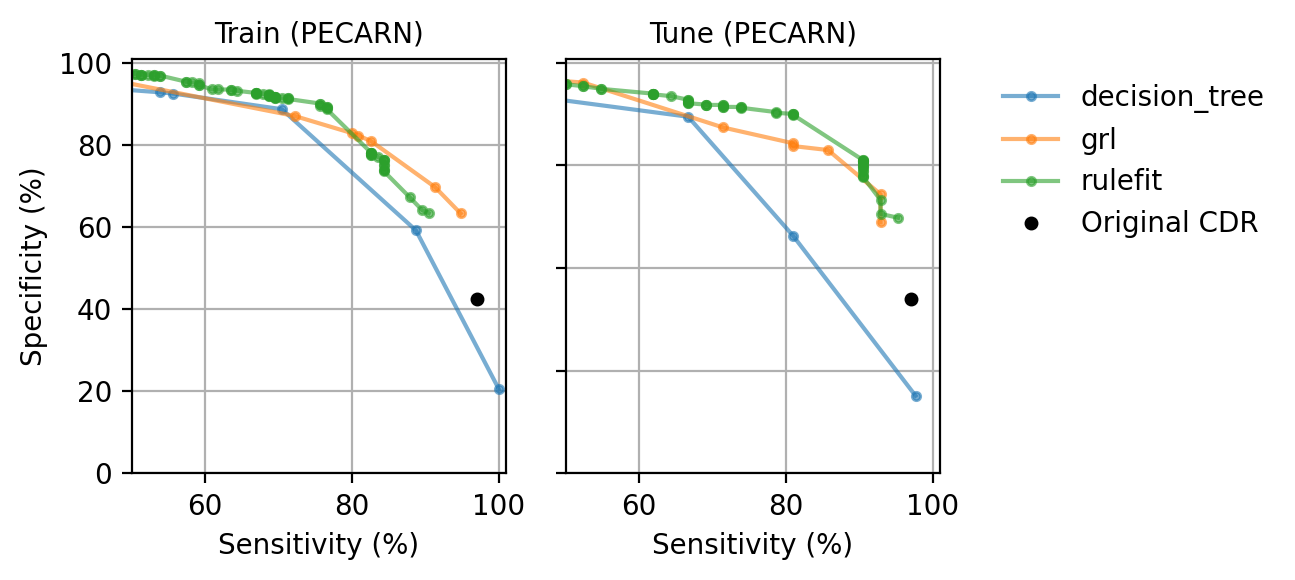

"x\nplt.figure(dpi=200, figsize=(C * 6, R * 6))\nfor i, suffix in enumerate(suffixes):\n    plt.subplot(R, C, i + 1)\n    plot_metrics(suffix, title=titles[i])\n    plt.xlim((80, 101))\n    plt.ylim((25, 70))\nplt.subplot(R, C, 1)    \nplt.legend()\nplt.tight_layout()\nviz.savefig('metrics_3_splits_zoom')\nplt.show()\nplt.legend(bbox_to_anchor=(1.05, 1.05))\n"

In [31]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
plt.savefig('figs/metrics_3_splits')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1591.61it/s]


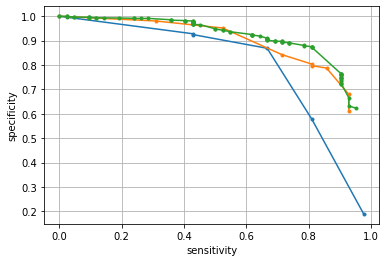

In [37]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)

                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

In [38]:
stats_list['_train']

,decision_tree,grl,rulefit
sens,1.00,0.95,0.90
spec,0.20,0.63,0.63
ppv,0.02,0.04,0.04
npv,1.00,1.00,1.00
lr+,1.26,2.58,2.47
lr-,0.00,0.08,0.15
brier_score,0.61,0.01,0.08
f1,0.04,0.08,0.07


In [39]:
stats_list['_tune']

,decision_tree,grl,rulefit
sens,0.98,0.93,0.95
spec,0.19,0.68,0.62
ppv,0.02,0.05,0.04
npv,1.00,1.00,1.00
lr+,1.20,2.90,2.52
lr-,0.13,0.11,0.08
brier_score,0.62,0.02,0.08
f1,0.04,0.09,0.08
